In [1]:
from  data_preprocessing import return_dataloaders
from computer_vision.auteencoders.models.VariationalAutoEncoder import VariationalAutoencoder
import torch
import torch.nn as nn
import tqdm.notebook as tq
import matplotlib.pyplot as plt

In [2]:
train_dataloader, val_dataloader, test_dataloader = return_dataloaders(128, 128,8)
model =VariationalAutoencoder(64)
device = ('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [3]:
def train(model, dataloader, criterion, opt, epoch, device=device):
  model.train()
  epoch_loss = 0.0
  for image, _ in tq.tqdm(dataloader):
    image = image.to(device)
    output  = model(image.view(-1, 784))

    loss = ((image - output)**2).sum() + model.encoder.kl

    opt.zero_grad()
    loss.backward()
    opt.step()

    epoch_loss += loss.item() * image.size(0)
  epoch_loss = epoch_loss / len(dataloader.dataset)
  print(f'Training, Epoch : {epoch} train_loss: {epoch_loss}')
  return model

In [4]:
def test(model, dataloader, criterion, opt, epoch, device=device):
  model.eval()
  epoch_loss = 0.0
  for image, _ in tq.tqdm(dataloader):
    with torch.no_grad():
      image = image.to(device).view(-1, 784)
      output, mu, sigma = model(image)

      part_loss = criterion(output, image)
      kl_div = torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
      loss = part_loss + kl_div

    epoch_loss += loss.item() * image.size(0)
  epoch_loss = epoch_loss / len(dataloader.dataset)
  print(f'Testing, Epoch: {epoch} test_loss: {epoch_loss}')

In [5]:
def plot_results(model, dataloader, epoch,num_images=8):
  img, _ = next(iter(test_dataloader))
  fig = plt.figure(figsize=(16,4))
  rows = 2
  columns = 8
  fig.suptitle(f"Epoch {epoch}")

  for i in range(num_images):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img[i].reshape(28, 28), cmap='gist_gray')
    plt.axis('off')

    fig.add_subplot(rows, columns, i + 1 + num_images)
    image = img.to(device).reshape(8,1,28,28)
    out = model(image)

    out = out[i].reshape(28,28).detach().cpu().numpy()
    plt.imshow(out, cmap='gist_gray')
    plt.axis('off')

In [6]:
model.to(device)
criterion = nn.BCELoss(reduction="sum")
lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 0 train_loss: 8457.989313020833


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 1 train_loss: 7326.453566927084


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 2 train_loss: 7124.338225260417


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 3 train_loss: 7029.921800520833


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 4 train_loss: 6977.708642708333


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

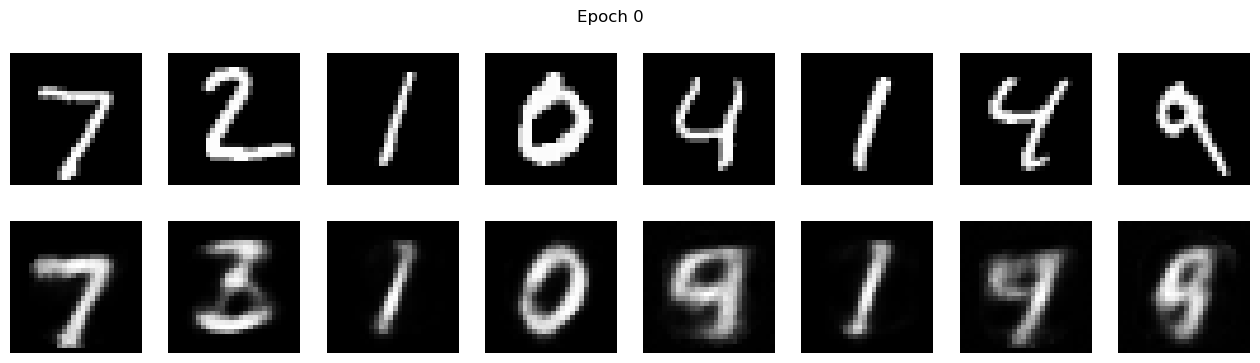

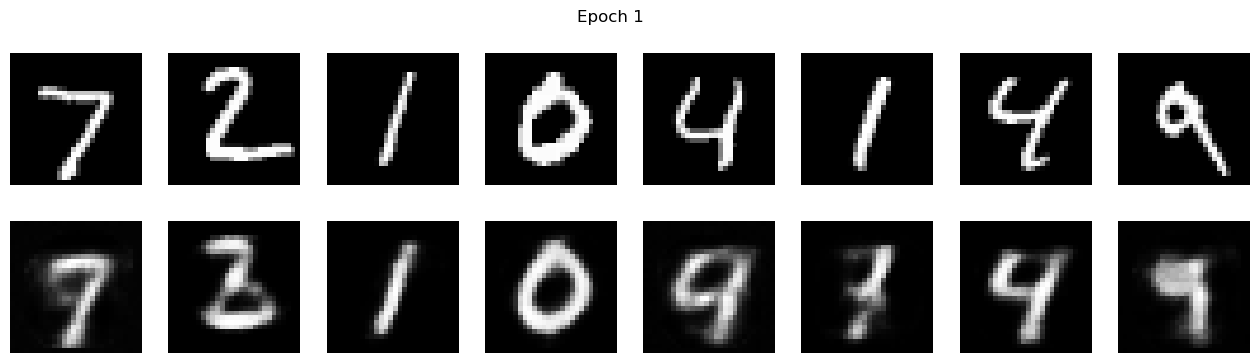

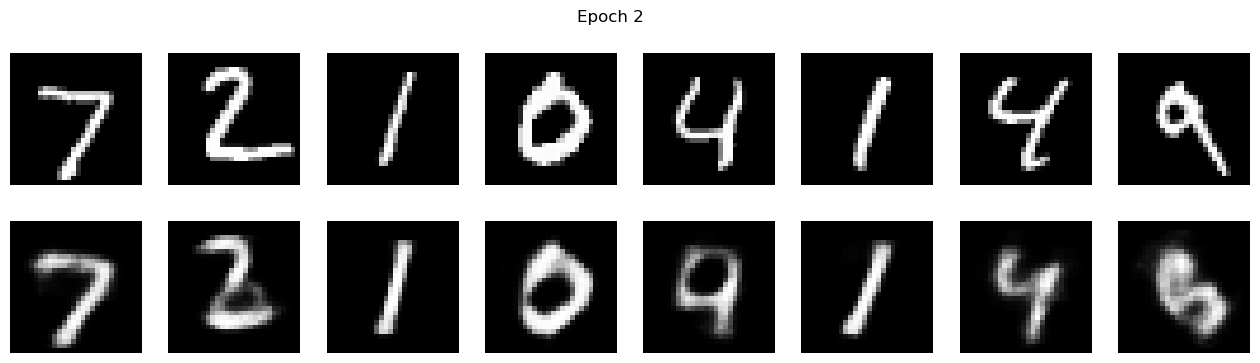

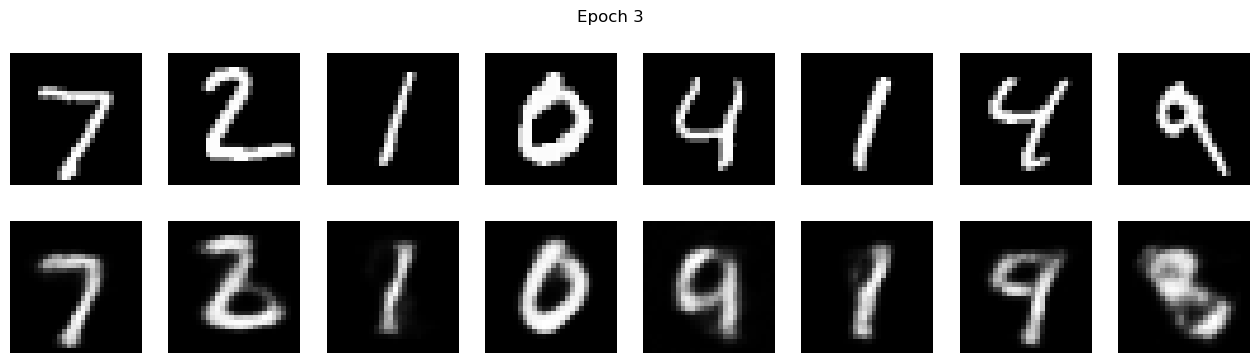

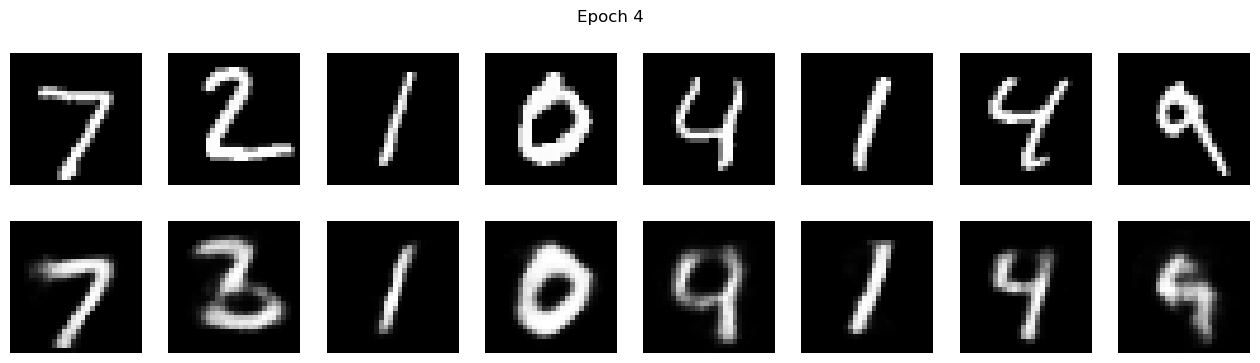

In [7]:
NUM_EPOCHS = 15
for epoch in range(NUM_EPOCHS):
  model = train(model, train_dataloader, criterion, optimizer, epoch)
  #test(model, val_dataloader, criterion, optimizer, epoch)
  plot_results(model, test_dataloader, epoch)